# Notebook example on how to generate a SACC cluster number counts file

In this notebook, we generate random data of clusters inside a redshift and mass intervals, which will be stored in a SACC file. This notebook exemplifies the default way to provide a number counts SACC file to firecrown.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
from astropy.table import Table
from numpy import random
import scipy
import matplotlib.pyplot as plt
import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData
from clmm import Cosmology
from clmm.support import mock_data as mock
import pandas as pd
import numpy as np
import pyccl as ccl
import sacc
clmm.__version__

'1.4.0'

## Generating Random Custers

We first generate a random number of clusters for each interval of redshift and proxy bins, which in this case is the real mass. Bear in mind that none of the values below represent any physical variables. They are random values for demonstration purposes only. They should not be interpreted as expected values for real data.

In [2]:
np.random.seed(10)

In [3]:
# redshift and mass range of the galaxy clusters
z_bin = [0.1,0.6]
logm_bin = np.array([13, 15.1]) #Solar Mass

# number of clusters in the ensemble
n_clusters = 3000

# random draw in the mass and redshift range (for simplicity, uniform instead of following an actual mass function)
cluster_m = 10 **((logm_bin[1] - logm_bin[0])*np.random.random(n_clusters) + logm_bin[0]) #in M_sun
cluster_z =  (z_bin[1] - z_bin[0])*np.random.random(n_clusters) + z_bin[0] 

# random normal draw of cluster concentration, around c_mean
c_mean = 4.
lnc = abs(np.log(c_mean) + 0.01*np.random.randn(n_clusters))
concentration = np.exp(lnc)

# randomly draw cluster positions on the sky
ra = np.random.random(n_clusters) * 360 #from 0 to 360 deg
sindec = np.random.random(n_clusters) * 2 - 1
dec = np.arcsin(sindec) * 180 / np.pi #from -90 to 90 deg
catalog = {
    "proxy_colname":cluster_m,
    "redshift_colname":cluster_z,
    "ra_colname": ra,
    "dec_colname":dec
}

[[511. 110.  57.  53.  31.]
 [537. 108.  61.  35.  37.]
 [502. 110.  64.  45.  42.]
 [475.  94.  53.  48.  27.]]
[0.10050556 0.22536498 0.35022439 0.47508381 0.59994323] [1.00145402e+13 2.59784304e+14 5.09554067e+14 7.59323831e+14
 1.00909359e+15 1.25886336e+15]


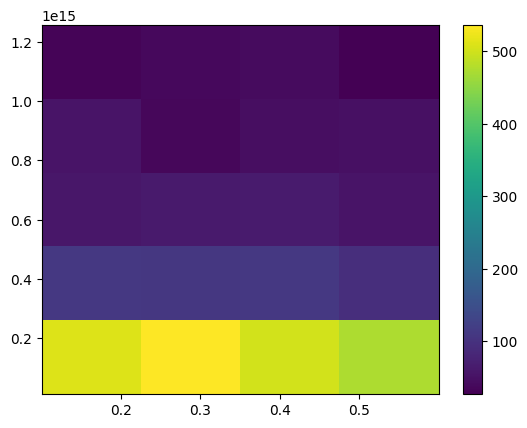

In [16]:

N_m = 5 # number of mass bins
N_z = 4 # number of redshift bins

data_lz, z_edges, m_edges, im  = plt.hist2d(cluster_z, cluster_m,
                                       bins=[N_z, N_m]);

print(data_lz)
print(z_edges, m_edges)
plt.colorbar()

Next, we create a covariance for the data, which should be a `numpy.ndarray`.

In [5]:
covariance =np.zeros((20,20))
np.fill_diagonal(covariance, np.sqrt(data_lz.flatten()))


## Storing In Sacc
We first initialize the SACC object and name as `s_count`. The file must have at least one tracer from the supported types, which shall be called `cluster_counts_true_mass`. So far, firecrown only has the implementation for real mass and real redshift. More options will be provided in the future. The tracer must be added as being the type `misc` and should be created with a directory to be added under `metadata`.

The metadata dictionary must be created with:
 * `Mproxy_type: 'true_mass'`. A `str` that represents the type of proxy. So far there is only the `true_mass` option.
 * `Mproxy_edges : m_edges`. A `numpy.array` of `floats` with the proxy bins.
 * `z_type : 'true_redshift'`. A string that represents the type of redshift. So far there is only the `true_redshift` option.
 * `z_edges : z_edges`. A `numpy.array` of `floats` with the redshift bins.
 * `sky_area: 439.78986`. A `float` with the sky area.  

With the metadata, the `add_tracer` function must be called

In [6]:
s_count = sacc.Sacc()

In [7]:
name = f'cluster_counts_true_mass'
metadata = {'Mproxy_type': 'true_mass',
            'Mproxy_edges' : np.array(m_edges),
            'z_type' : 'true_redshift', 
            'z_edges' : np.array(z_edges),
            'sky_area': 439.78986          
        }
s_count.add_tracer('misc', name, metadata=metadata)

Having the tracer, the user must call the `add_data` function for all the data points using the same tracer. The data should be the number of clusters in each bin of redsfhit and proxy. The order of the data is really important: the user must add the data  for each redshift bin iterating then over the proxy bins, that is, filling a row-major (z, proxy) matrix. 

In [8]:
# One of our identifiers is a standard type name that is predefined
cluster_count = sacc.standard_types.cluster_mass_count_wl
for i in range(N_z): 
    for j in range(N_m):
        # Cluster number counts data
        tracer = name
        value = data_lz[i][j]
        s_count.add_data_point(cluster_count, (tracer,), value, err=1.)

Lastly, the user must add the covariance and call the necessary functions to save the SACC file.

In [9]:
s_count.add_covariance(covariance)
s_count.to_canonical_order()
s_count.save_fits("clusters.sacc", overwrite=True)

## Loading the file

In [12]:
sacc_data = sacc.Sacc.load_fits("./clusters.sacc")
tracer = sacc_data.get_tracer(name)

print(sacc_data.data[0].__dict__)
print(sacc_data.data[0].value)
print(tracer.metadata)

{'data_type': 'cluster_mass_count_wl', 'tracers': ('cluster_counts_true_mass',), 'value': 511.0, 'tags': {'err': 1.0}}
511.0
{'z_type': 'true_redshift', 'sky_area': 439.78986, 'z_edges': array([0.10050556, 0.22536498, 0.35022439, 0.47508381, 0.59994323]), 'Mproxy_edges': array([1.00145402e+13, 2.59784304e+14, 5.09554067e+14, 7.59323831e+14,
       1.00909359e+15, 1.25886336e+15]), 'Mproxy_type': 'true_mass'}
